In [100]:
# !pip install lightgbm
# !pip install yellowbrick
# !pip install ipywidgets
# !pip install pandas-profiling
# !jupyter nbextension enable --py widgetsnbextension

In [101]:
import os
import random
import sqlite3
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import stats
from scipy.stats import norm
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.metrics import max_error
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae, explained_variance_score

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

%matplotlib inline

In [102]:
database = sqlite3.connect(os.path.join(os.getcwd(), "fypdbmain.sqlite"))

In [103]:
tickers = {
    "EVs": "TSLA",
    "Finance": "MS",
    "Tech": "GOOGL"
}

categories = ["EVs","Finance","Tech"]

tableName = {
    "EVs": "evDataAggr",
    "Finance": "financeDataAggr",
    "Tech": "techDataAggr"
}


In [104]:
def load_datasets(tickers, categories):
    tweet_dfs = dict()
    
    stock_dfs = dict()
    for category in categories:
      ticker = tickers[category]
      #ToDo make this line general
      tweet_df = pd.read_sql_query(f"SELECT * from {tableName[category]}",database)
      tweet_df = tweet_df.drop(columns = ['category'])
      tweet_df["date"] = tweet_df["date"].astype("datetime64")
      tweet_df["count"] = tweet_df["count"].astype("int32")
      tweet_df["neg_count"] = tweet_df["neg_count"].astype("int32")
      tweet_df["neu_count"] = tweet_df["neu_count"].astype("int32")
      tweet_df["pos_count"] = tweet_df["pos_count"].astype("int32")
      tweet_df["neg_score"] = tweet_df["neg_score"].astype("float64")
      tweet_df["neu_score"] = tweet_df["neu_score"].astype("float64")
      tweet_df["pos_score"] = tweet_df["pos_score"].astype("float64")
      tweet_df["wt_neg"] = tweet_df["wt_neg"].astype("float64")
      tweet_df["wt_neu"] = tweet_df["wt_neu"].astype("float64")
      tweet_df["wt_pos"] = tweet_df["wt_pos"].astype("float64")
      #tweet_df["mood"] = (tweet_df["wted_pos"] - tweet_df["wted_neg"]) / (tweet_df["wted_pos"] + tweet_df["wted_neu"] + tweet_df["wted_neg"])

      if(ticker!='GOOGL'):
        tweet_df["neg_count"] = -1 * tweet_df["neg_count"]
        tweet_df["neg_score"] = -1 * tweet_df["neg_score"]
        tweet_df["wt_neg"] = -1 * tweet_df["wt_neg"]
        tweet_df["neu_count"] = -1 * tweet_df["neu_count"]
        tweet_df["neu_score"] = -1 * tweet_df["neu_score"]
        tweet_df["wt_neu"] = -1 * tweet_df["wt_neu"]
        tweet_df["pos_count"] = -1 * tweet_df["pos_count"]
        tweet_df["pos_score"] = -1 * tweet_df["pos_score"]
        tweet_df["wt_pos"] = -1 * tweet_df["wt_pos"]

      tweet_dfs[ticker] = tweet_df.copy(deep=True)

      stock_df = pd.read_sql_query(f"SELECT * from stockDataAggr where category ='{category}'",database)
      stock_df = stock_df.drop(columns = ['category', 'ticker','aggrPercent'])

      stock_df["stockDate"] = stock_df["stockDate"].astype("datetime64")
      stock_df["open"] = stock_df["open"].astype("float64")
      stock_df["close"] = stock_df["close"].astype("float64")
      stock_df["high"] = stock_df["high"].astype("float64")
      stock_df["low"] = stock_df["low"].astype("float64")

      stock_df.rename(columns = {'stockDate': 'date'}, inplace = True)
      stock_dfs[ticker] = stock_df.copy(deep=True)
      del tweet_df, stock_df
            
    return tweet_dfs, stock_dfs

In [105]:
tweet_dfs, stock_dfs = load_datasets(tickers, categories)

In [106]:
tweet_dfs["MS"]

,date,neg_count,neu_count,pos_count,neg_score,neu_score,pos_score,wt_neg,wt_neu,wt_pos,count
0,2022-08-02,-766,-127,-303,-336.0,-115.406570,-196.611622,-239.981812,-152.470932,-293.251112,320
1,2022-08-01,-427,-83,-150,-194.0,-69.494362,-115.738205,-174.767426,-77.543838,-154.309587,195
2,2022-08-03,-1359,-451,-497,-411.0,-285.696716,-395.129700,-274.173561,-417.545763,-535.736023,405
3,2022-08-04,-1479,-361,-744,-374.0,-234.666542,-372.979546,-317.353912,-471.263652,-580.721989,427
4,2022-08-05,-1183,-358,-405,-420.0,-226.413116,-297.240101,-229.346766,-323.883955,-422.728630,436
...,...,...,...,...,...,...,...,...,...,...,...
238,2023-03-27,-616,-148,-284,-184.0,-148.681401,-274.666202,-192.652397,-234.922952,-482.123691,318
239,2023-03-28,-187,-54,-97,-36.0,-47.810618,-95.097759,-44.091623,-75.500702,-112.091591,47
240,2023-03-29,-498,-126,-172,-200.0,-123.980578,-195.046607,-178.972815,-142.884097,-225.294882,203
241,2023-03-30,-522,-104,-277,-141.0,-109.790652,-237.557411,-174.651938,-117.151378,-262.639870,207


In [107]:
stock_dfs["MS"]

,date,open,close,high,low
0,2022-08-01,83.660004,84.089996,84.540001,83.010002
1,2022-08-02,83.330002,83.529999,84.589996,82.959999
2,2022-08-03,84.680000,85.050003,85.589996,84.120003
3,2022-08-04,85.199997,85.360001,85.650002,84.800003
4,2022-08-05,84.989998,86.129997,86.709999,84.709999
...,...,...,...,...,...
238,2023-03-27,86.059998,84.639999,86.320000,84.360001
239,2023-03-28,84.559998,84.879997,85.169998,83.930000
240,2023-03-29,85.930000,86.239998,86.349998,85.349998
241,2023-03-30,87.260002,86.110001,87.610001,85.459999


In [108]:
def merge_datasets(categories, tickers, ticker_dfs, stock_dfs):
    merged_dfs = dict()
    
    for category in categories:
        ticker = tickers[category]
            
        temp_tweet_df = tweet_dfs[ticker].copy(deep=True)
        temp_stock_df = stock_dfs[ticker].copy(deep=True)

        temp_merged_df = pd.merge(temp_stock_df, temp_tweet_df, on=['date'])
        temp_merged_df = temp_merged_df.sort_values(by=['date']).reset_index(drop=True)
        
        
        merged_dfs[ticker] = temp_merged_df.copy(deep=True)
        
        print(f"Data dimensions for {ticker}:", temp_merged_df.shape, "\n")
        
        del temp_tweet_df, temp_stock_df, temp_merged_df
            
    return merged_dfs

In [127]:
def normalize_datasets(categories, tickers, merged_dfs, reduced=False, output_label='close'):
    norm_dfs = dict()
    
    scaler = MinMaxScaler()
    
    for category in categories:
        
        ticker = tickers[category]
        temp_norm_df = merged_dfs[ticker].copy(deep=True)
        
        temp_norm_df = temp_norm_df.drop(columns=['date'])

        temp_norm_df = scaler.fit_transform(temp_norm_df)

        if(reduced == False):

          temp_norm_df = pd.DataFrame(temp_norm_df, columns = [ 'open', 'close', 'high', 'low', \
                                                                'count','neg_score','neu_score', 'pos_score', \
                                                                'wt_neg', 'wt_neu', 'wt_pos', \
                                                                'neg_count', 'neu_count', 'pos_count'])
        else:
          columns = ['open', 'wt_neg', 'wt_neu', 'wt_pos','prev_open','prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', output_label]
          print(columns)
          temp_norm_df = pd.DataFrame(temp_norm_df, columns = columns)
        
        
        norm_dfs[ticker] = temp_norm_df.copy(deep=True)
        
        print(f"Data dimensions for {ticker}:", temp_norm_df.shape, "\n")
        
        del temp_norm_df
            
    return norm_dfs

In [110]:
merged_dfs = merge_datasets(categories, tickers, tweet_dfs, stock_dfs)

Data dimensions for TSLA: (243, 15) 

Data dimensions for MS: (243, 15) 

Data dimensions for GOOGL: (243, 15) 



In [111]:
def plot_corr_heatmaps(categories, tickers, norm_dfs):
    cmaps = ['YlOrBr', 'YlOrRd', 'YlGnBu', 'PuBuGn', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu']
    for category in categories:
        ticker=tickers[category]
        plt.figure(figsize=(10,6))
        sns.heatmap(norm_dfs[ticker].corr('spearman'),cmap='RdYlGn',annot=True, linewidths=0.2)
        plt.title(f'Correlation Heatmap For {ticker}', fontsize=14)

        plt.show()

In [112]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

In [113]:
def RMSE(y_true, y_pred):
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    
    return round(RMSE, 6)

In [114]:
def print_metrics(model, X_train, X_test, y_test):
    
    n_points = X_train.shape[0] #number of datapoints
    n_features = X_train.shape[1] #number of features

    #predict probabilities for test set
    y_hat = model.predict(X_test)

    rmse_val = RMSE(y_test.reshape(-1,1), y_hat)
    print('RMSE:\t\t\t%f' % rmse_val)
    
    mse_val = mse(y_test.reshape(-1, 1), y_hat)
    print('MSE:\t\t\t%f' % mse_val)
    
    mae_val = mae(y_test.reshape(-1, 1), y_hat)
    print('MAE:\t\t\t%f' % mae_val)

    r2 = r2_score(y_test.reshape(-1,1), y_hat)
    print('R2 Score:\t\t%f' % r2)

    adj_r2 = 1-(1-r2)*(n_points-1)/(n_points-n_features-1)
    print('Adj. R2 Score:\t\t%f' % adj_r2)
    
    exp_var_score = explained_variance_score(y_test.reshape(-1,1), y_hat)
    print('Exp. Variance Score:\t%f' % exp_var_score)

    max_err = max_error(y_test.reshape(-1,1), y_hat)
    print('Max Error:\t\t%f' % max_err)

In [132]:
def plot_prediction_graph(model, X_train, X_test, y_test, output_labels_unscaled, dates, ticker,output_label='close'):
    predicted  = model.predict(X_test)
    test_label = y_test.reshape(-1,1)
    predicted = np.array(predicted).reshape(-1,1)
    print("Predicted","\t","Value")
    for i in range(len(predicted)):
      print(predicted[i],"\t",test_label[i])
    len_t = len(X_train)

    for j in range(len_t , len_t + len(X_test)):
        temp = output_labels_unscaled[j]
        test_label[j - len_t] = test_label[j - len_t] * temp + temp
        predicted[j - len_t] = predicted[j - len_t] * temp + temp

    plt.figure(figsize=(15, 10))
    plt.plot(dates, predicted, color = 'green', label = 'Predicted ' + output_label, linewidth=2)
    plt.plot(dates, test_label, color = 'red', label = 'Actual ' + output_label, linewidth=2)
    plt.title('Stock - '+output_label+' Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 
    plt.legend(loc='best')
    
    # if ticker in ['TSLA', 'XOM', 'MSFT', 'MRNA']:
    #     plt.savefig(f'images/catboost-prediction-graph-{ticker}', transparent=True, dpi=400)
    
    plt.show()

In [116]:
def print_feature_importance(model, df_cols, ticker):
    sorted_feature_importance = model.feature_importances_.argsort()

    plt.figure(figsize=(10, 5))
    plt.barh(df_cols[sorted_feature_importance], 
             model.feature_importances_[sorted_feature_importance], 
             color = 'turquoise')
    plt.title(f"LightGBM Feature Importance - {ticker}")
    plt.show()

In [117]:
def get_train_test_set(ticker, norm_df, output_label = 'close'):
    temp_df = norm_df.copy(deep = True)
    output_values = temp_df.loc[:, output_label]
    temp_df.drop(columns = [output_label], inplace = True)
    
    temp_df = temp_df.to_numpy()
    output_values = output_values.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(temp_df, output_values, \
                                                        test_size = 0.2, random_state = 3, shuffle=False)
    
    Xd_train, Xd_test, yd_train, yd_test = train_test_split(merged_dfs[ticker], merged_dfs[ticker][output_label], \
                                                        test_size = 0.2, random_state = 3, shuffle=False)

    
    test_dates = Xd_test['date'] #Collect Test data dates
    
    while len(test_dates) > len(y_test): #in case the array size is higher for dates
        test_dates = test_dates[:-1].copy()
    
    
    del Xd_train, Xd_test, yd_train, yd_test #Run GC
    del temp_df, output_values #Run GC
    
    return X_train, X_test, y_train, y_test, test_dates

In [145]:
def get_unscaled_output_labels(categories, tickers, dfs, output_label='close'):
    unscaled_op_labels = dict()
    
    for category in categories:
        ticker=tickers[category]
        # print(output_label)
        unscaled_op_labels[ticker] = dfs[ticker].loc[:, output_label].copy(deep=True)

    return unscaled_op_labels

In [144]:
def train_and_test_model(categories, tickers, norm_dfs, unscaled_op_labels, output_label='close'):
#     params = {'depth': 2,
#               'iterations': 200,
#               'learning_rate': 0.03,
#               'l2_leaf_reg': 3}

    lgb_params = {
    'objective': 'regression',
    'metric': 'l1',  # MAE
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 1,
    'max_depth': 3,
    'n_estimators': 500,
    'random_state': 3,
    'n_jobs': 2
}


    model = lgb.LGBMRegressor(**lgb_params)
    
    for category in categories:
        ticker=tickers[category]
        print(f"======CURRENTLY WORKING ON {ticker}======")
        
        X_train, X_test, y_train, y_test, dates = get_train_test_set(ticker, norm_dfs[ticker], 
                                                                      output_label)
        
        model.fit(X_train, y_train)
        
        print_feature_importance(model, norm_dfs[ticker].columns.values, ticker)
        print_metrics(model, X_train, X_test, y_test)
        plot_prediction_graph(model, X_train, X_test, y_test, unscaled_op_labels[ticker], dates, ticker,output_label)
        
        
        print(f"======FINISHED WORKING ON {ticker}======")

In [120]:
def append_prev_day_value(categories, tickers, merged_dfs, output_label='close'):
    prev_open_dfs = dict()

    column_to_drop = ['count', 'neg_score', 'neu_score', 'pos_score', 'neg_count', 'neu_count', 'pos_count']
    for i in ['low','high','close']:
      if(i != output_label):
        column_to_drop.append(i)

    
    for category in categories:
        ticker = tickers[category]
    
        t_df = merged_dfs[ticker].copy(deep = True)
        t_df = t_df.drop(columns = column_to_drop)

        t_minus1_df = t_df.copy(deep = True).drop(columns = [output_label])
        t_minus1_df = t_minus1_df.rename(columns = {'open': 'prev_open','wt_neg':'prev_wt_neg', 'wt_neu':'prev_wt_neu', 'wt_pos':'prev_wt_pos'})

        t_minus1_df['date'] = t_minus1_df['date'] + datetime.timedelta(1)

        #t_df = t_df.drop(columns=['open','wt_neg', 'wt_neu', 'wt_pos'])

        prev_open_df = pd.merge(t_df, t_minus1_df, on = ['date'])

        prev_open_df = prev_open_df[['date', 'open', 'wt_neg', 'wt_neu', 'wt_pos','prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', output_label]]

        #prev_open_df = prev_open_df.rename(columns = {'open': 'prev_open','wt_neg':'prev_wt_neg', 'wt_neu':'prev_wt_neu', 'wt_pos':'prev_wt_pos'})
        
        #prev_open_df = prev_open_df.drop(columns = ['prev_open'])
        
        prev_open_dfs[ticker] = prev_open_df.copy(deep=True)
        
        del prev_open_df #Perform GC

    return prev_open_dfs

# **Predicting Close Value**

In [121]:
both_open_dfs = append_prev_day_value(categories, tickers, merged_dfs, output_label='close')

both_open_dfs['TSLA']

,date,open,wt_neg,wt_neu,wt_pos,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,close
0,2022-08-02,294.003326,-22.682993,-25.073643,-37.357318,301.276672,-16.876412,-26.904634,-41.171774,300.586670
1,2022-08-03,305.000000,-2.331892,-6.009396,-13.196395,294.003326,-22.682993,-25.073643,-37.357318,307.396667
2,2022-08-04,311.000000,-1.167563,-2.196746,-3.635691,305.000000,-2.331892,-6.009396,-13.196395,308.633331
3,2022-08-05,302.670013,-16.216868,-16.855830,-160.879937,311.000000,-1.167563,-2.196746,-3.635691,288.170013
4,2022-08-06,298.840000,-5.747857,-10.603171,-13.781130,302.670013,-16.216868,-16.855830,-160.879937,289.300000
...,...,...,...,...,...,...,...,...,...,...
237,2023-03-27,194.419998,-232.793960,-281.636459,-465.958222,193.720000,-14.594635,-21.290344,-30.107518,191.809998
238,2023-03-28,192.000000,-13.191043,-12.029059,-33.769606,194.419998,-232.793960,-281.636459,-465.958222,189.190002
239,2023-03-29,193.130005,-50.816797,-73.301693,-115.862161,192.000000,-13.191043,-12.029059,-33.769606,193.880005
240,2023-03-30,195.580002,-150.363192,-88.522910,-161.982104,193.130005,-50.816797,-73.301693,-115.862161,195.279999


In [128]:
both_open_norm_dfs = normalize_datasets(categories, tickers, both_open_dfs,True,output_label='close')

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'close']
Data dimensions for TSLA: (242, 9) 

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'close']
Data dimensions for MS: (242, 9) 

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'close']
Data dimensions for GOOGL: (242, 9) 



In [129]:
both_open_norm_dfs['TSLA']

,open,wt_neg,wt_neu,wt_pos,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,close
0,0.915351,0.930269,0.986030,0.981093,0.950208,0.948169,0.984976,0.979141,0.956598
1,0.968051,0.993008,0.997001,0.993455,0.915351,0.930269,0.986030,0.981093,0.990442
2,0.996805,0.996598,0.999194,0.998347,0.968051,0.993008,0.997001,0.993455,0.996587
3,0.956885,0.950203,0.990759,0.917889,0.996805,0.996598,0.999194,0.998347,0.894891
4,0.938530,0.982477,0.994357,0.993156,0.956885,0.950203,0.990759,0.917889,0.900507
...,...,...,...,...,...,...,...,...,...
237,0.438115,0.282526,0.838391,0.761786,0.434760,0.955204,0.988207,0.984802,0.416012
238,0.426518,0.959531,0.993536,0.982928,0.438115,0.282526,0.838391,0.761786,0.402992
239,0.431933,0.843536,0.958277,0.940923,0.426518,0.959531,0.993536,0.982928,0.426300
240,0.443674,0.536649,0.949518,0.917325,0.431933,0.843536,0.958277,0.940923,0.433257


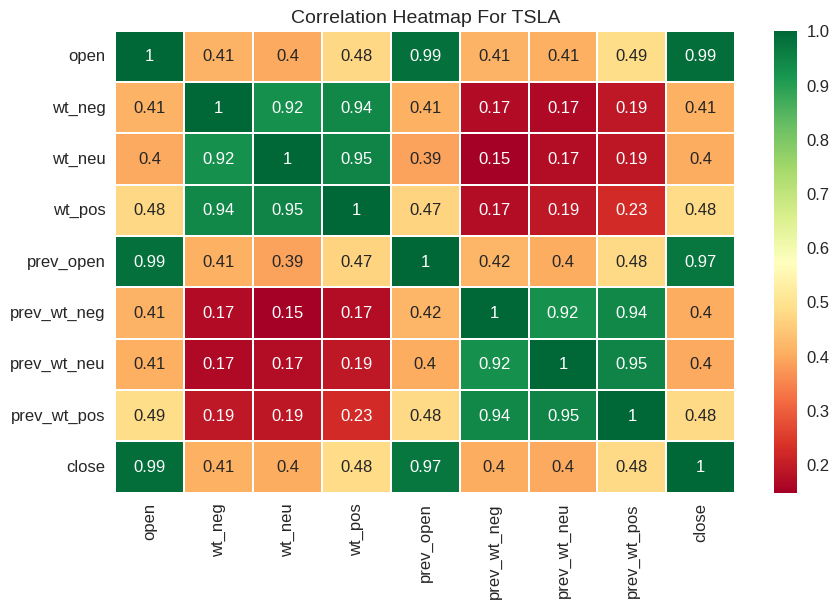

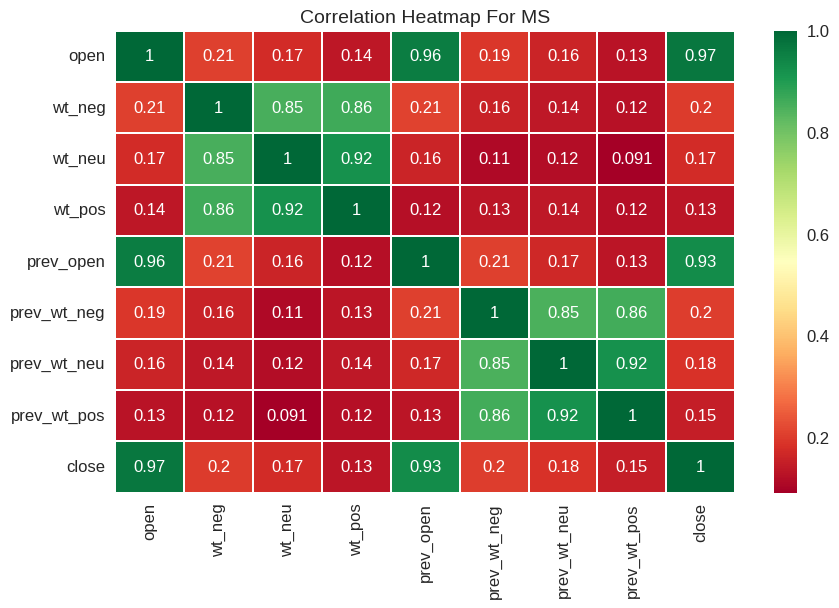

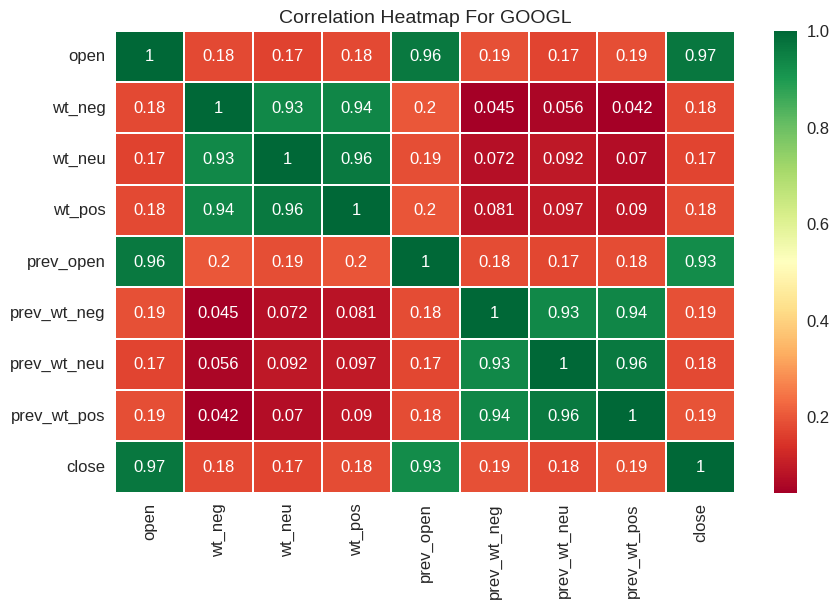

In [130]:
plot_corr_heatmaps(categories, tickers, both_open_norm_dfs)

======CURRENTLY WORKING ON TSLA======
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


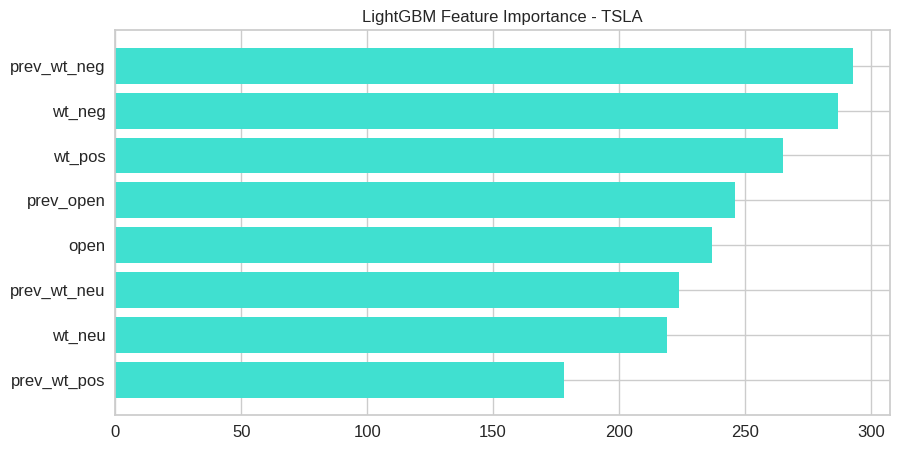

RMSE:			0.034294
MSE:			0.001176
MAE:			0.025042
R2 Score:		0.554327
Adj. R2 Score:		0.534950
Exp. Variance Score:	0.570087
Max Error:		0.092891
Predicted 	 Value
[0.42584155] 	 [0.43564257]
[0.43595389] 	 [0.43285955]
[0.42622501] 	 [0.43007652]
[0.40979299] 	 [0.50268362]
[0.49119797] 	 [0.52748237]
[0.47985513] 	 [0.46685216]
[0.44316774] 	 [0.4980121]
[0.44978936] 	 [0.47082794]
[0.46573487] 	 [0.457211]
[0.52177998] 	 [0.45040253]
[0.52093259] 	 [0.44364374]
[0.45795905] 	 [0.46098797]
[0.44660204] 	 [0.46700132]
[0.44580874] 	 [0.44120864]
[0.44419284] 	 [0.46794552]
[0.48081275] 	 [0.48131397]
[0.44784911] 	 [0.49463275]
[0.48024102] 	 [0.48509097]
[0.51617604] 	 [0.47048008]
[0.38897896] 	 [0.41148987]
[0.4326456] 	 [0.445731]
[0.41067429] 	 [0.43584136]
[0.42328592] 	 [0.43087167]
[0.43492399] 	 [0.42595168]
[0.38811514] 	 [0.39563664]
[0.35259233] 	 [0.36725971]
[0.3837893] 	 [0.32213496]
[0.33843833] 	 [0.32471922]
[0.35504345] 	 [0.32730344]
[0.34347754] 	 [0.32859556]
[0.3

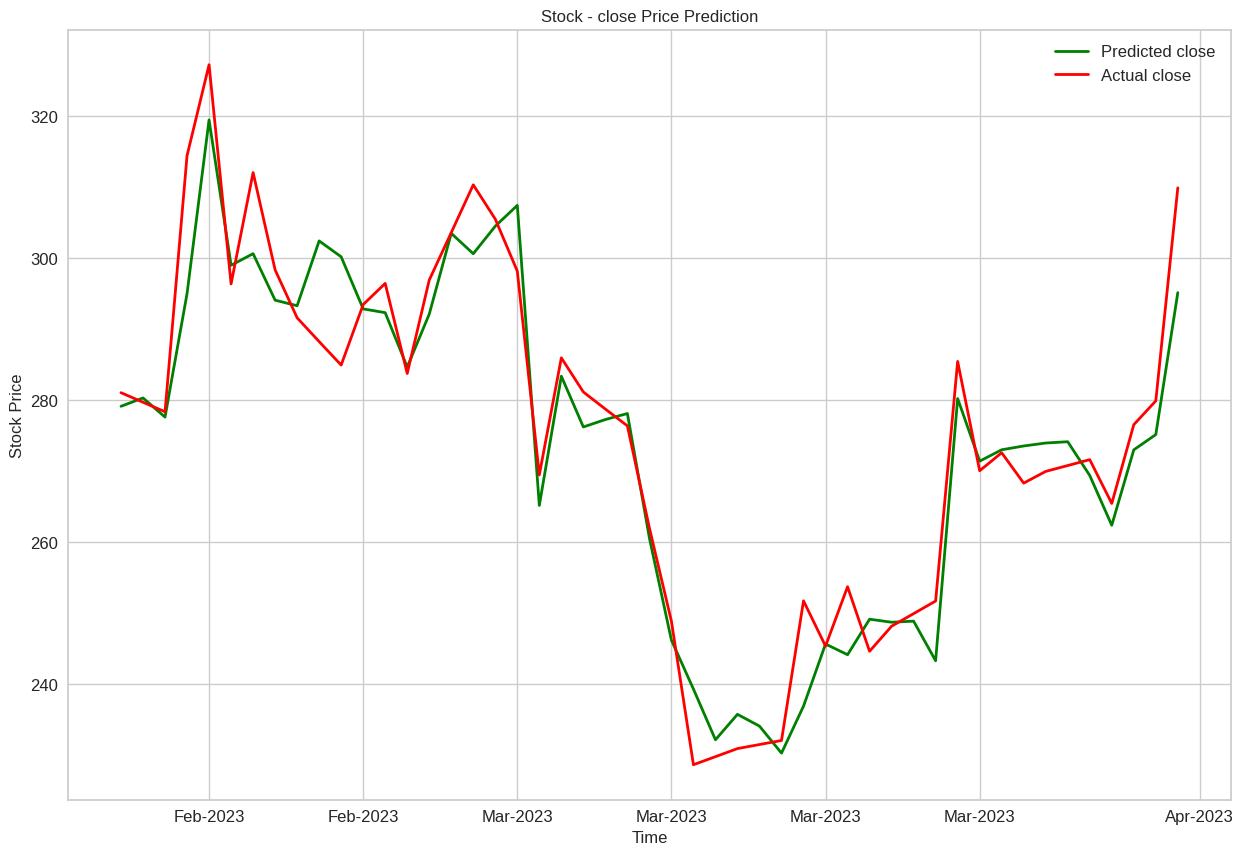

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


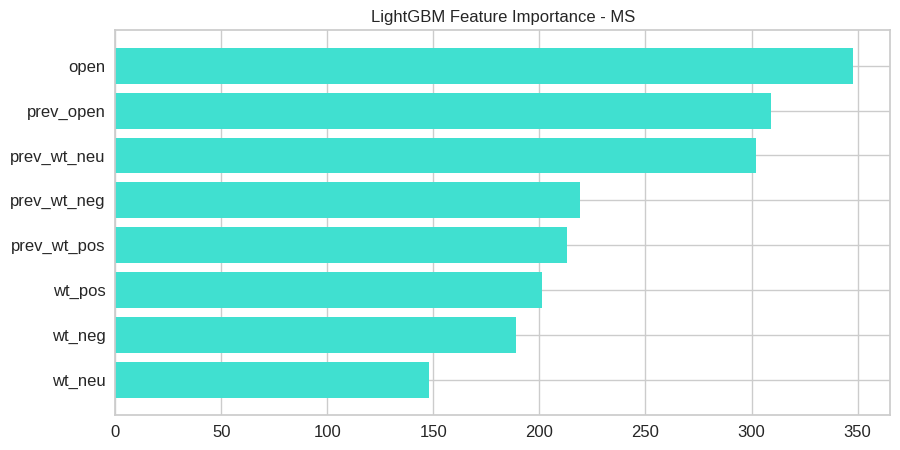

RMSE:			0.077176
MSE:			0.005956
MAE:			0.058014
R2 Score:		0.888705
Adj. R2 Score:		0.883866
Exp. Variance Score:	0.904305
Max Error:		0.282552
Predicted 	 Value
[0.90622168] 	 [0.92596937]
[0.9280261] 	 [0.93576177]
[0.88958073] 	 [0.94516247]
[0.89781503] 	 [0.98942405]
[0.83940876] 	 [1.]
[0.88812358] 	 [0.95064622]
[0.89787704] 	 [0.94829612]
[0.93295568] 	 [0.91147661]
[0.90198396] 	 [0.8930669]
[0.94962257] 	 [0.88366619]
[0.87871037] 	 [0.8742656]
[0.89143837] 	 [0.86055601]
[0.91367449] 	 [0.88679984]
[0.86951939] 	 [0.87739894]
[0.89293699] 	 [0.85781425]
[0.85412597] 	 [0.84802185]
[0.88440173] 	 [0.83822933]
[0.90822942] 	 [0.83039553]
[0.86819758] 	 [0.81825303]
[0.84541638] 	 [0.81394437]
[0.9007066] 	 [0.90207599]
[0.89358014] 	 [0.9028593]
[0.87371653] 	 [0.903251]
[0.92830604] 	 [0.90403427]
[0.92481968] 	 [0.81316082]
[0.92111558] 	 [0.80689384]
[0.9445182] 	 [0.66196611]
[0.70652338] 	 [0.57775169]
[0.60123985] 	 [0.53740688]
[0.60373973] 	 [0.51703868]
[0.58498064] 

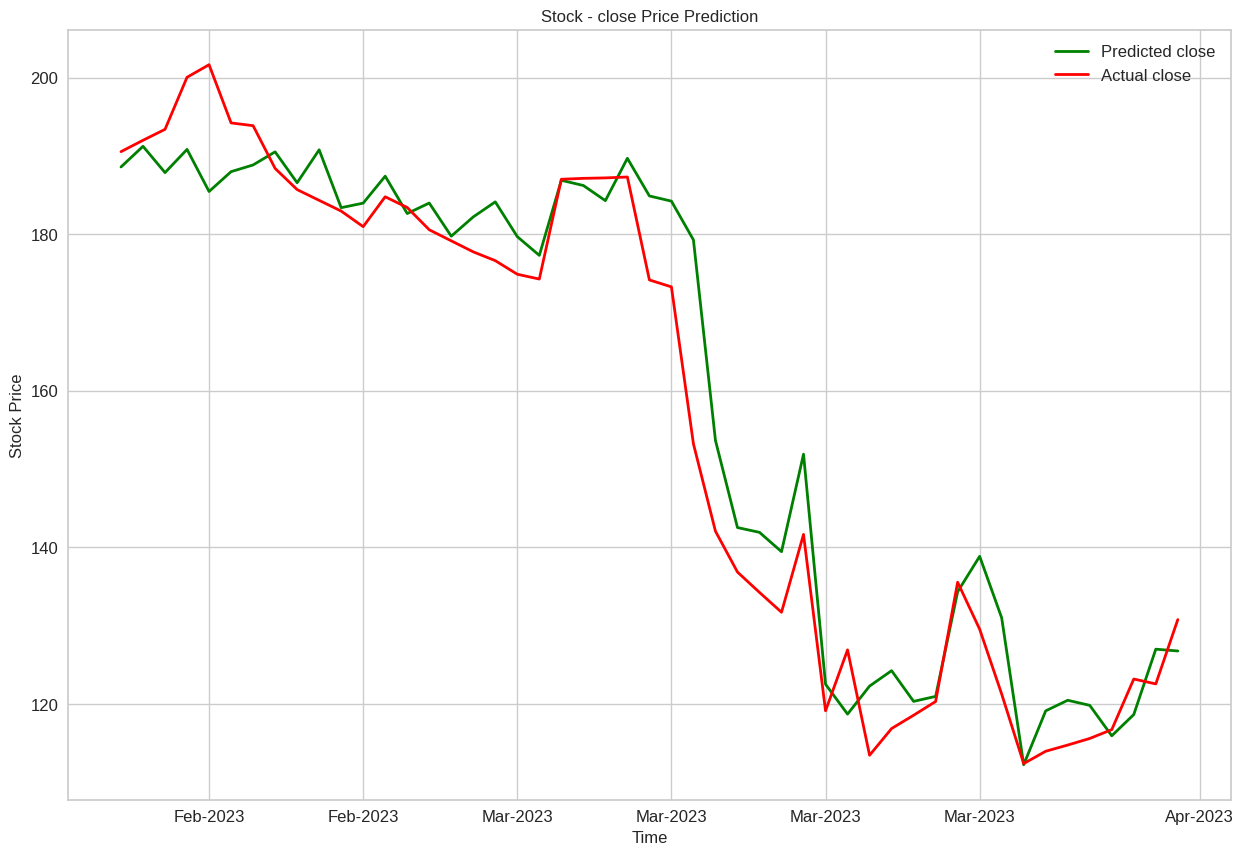

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


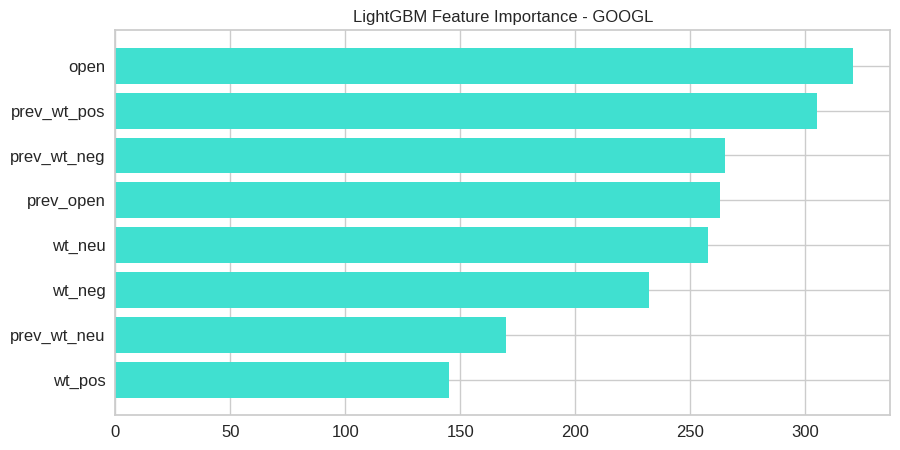

RMSE:			0.046498
MSE:			0.002162
MAE:			0.036136
R2 Score:		0.872939
Adj. R2 Score:		0.867414
Exp. Variance Score:	0.879317
Max Error:		0.126285
Predicted 	 Value
[0.28681266] 	 [0.28874513]
[0.34466222] 	 [0.28900387]
[0.34899601] 	 [0.28926262]
[0.25423303] 	 [0.29107372]
[0.25335578] 	 [0.34954725]
[0.31273669] 	 [0.31254855]
[0.30918569] 	 [0.28253551]
[0.26715253] 	 [0.24941784]
[0.24264417] 	 [0.23285898]
[0.25560222] 	 [0.22457955]
[0.25864491] 	 [0.21630014]
[0.18908112] 	 [0.21267792]
[0.18205493] 	 [0.19301419]
[0.12798003] 	 [0.14747728]
[0.17762117] 	 [0.15705044]
[0.14264448] 	 [0.16196636]
[0.13081234] 	 [0.16662361]
[0.14002518] 	 [0.1715394]
[0.16139945] 	 [0.17930144]
[0.11614562] 	 [0.22173349]
[0.26319713] 	 [0.26442436]
[0.23504634] 	 [0.28357049]
[0.24516567] 	 [0.29314358]
[0.28774559] 	 [0.30271659]
[0.32759742] 	 [0.26985771]
[0.24255073] 	 [0.27994824]
[0.27962482] 	 [0.23001292]
[0.16374604] 	 [0.18628711]
[0.16968052] 	 [0.19249676]
[0.18057502] 	 [0.19560154

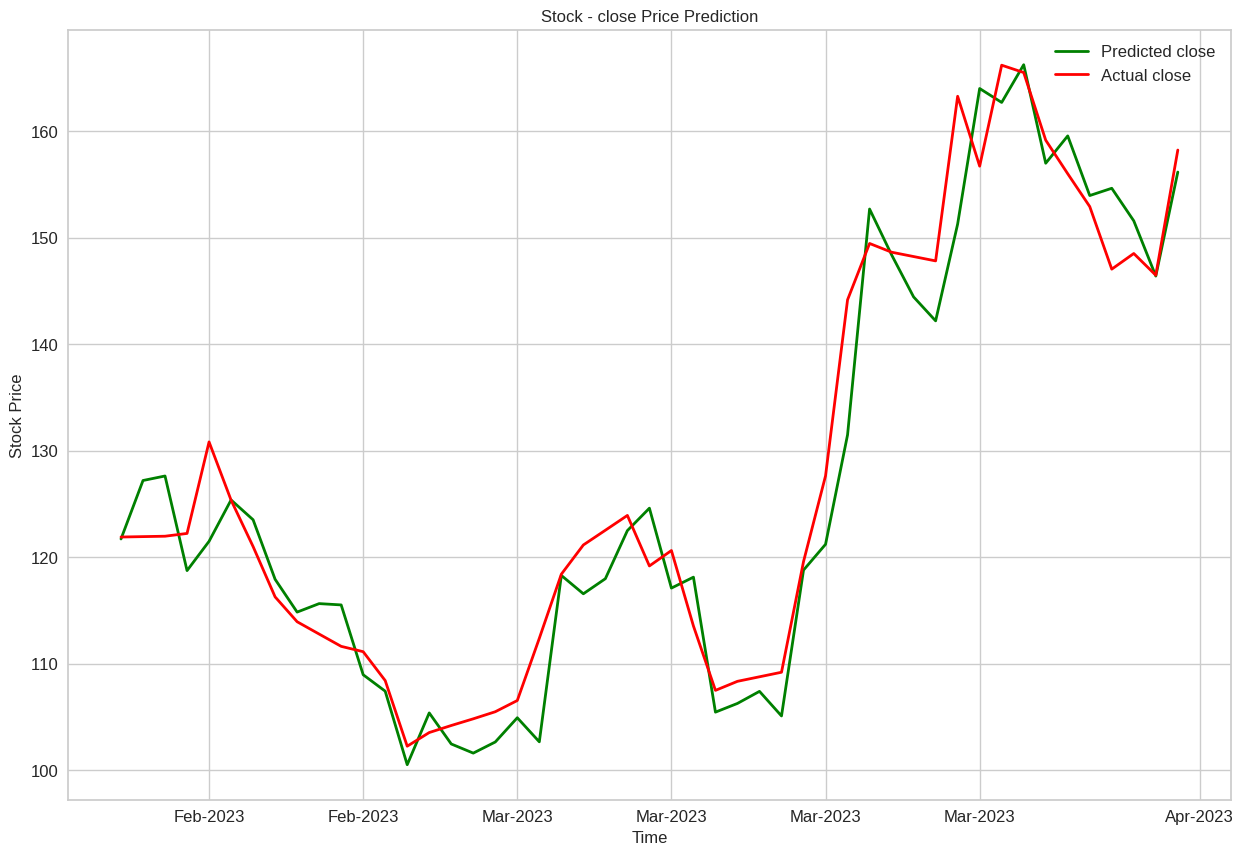

======FINISHED WORKING ON GOOGL======


In [133]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, both_open_dfs, output_label='close')
train_and_test_model(categories, tickers, both_open_norm_dfs, unscaled_op_labels)

# **Predicting High value**

In [141]:
both_open_dfs = append_prev_day_value(categories, tickers, merged_dfs, output_label='high')

both_open_dfs['TSLA']

,date,open,wt_neg,wt_neu,wt_pos,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,high
0,2022-08-02,294.003326,-22.682993,-25.073643,-37.357318,301.276672,-16.876412,-26.904634,-41.171774,307.833344
1,2022-08-03,305.000000,-2.331892,-6.009396,-13.196395,294.003326,-22.682993,-25.073643,-37.357318,309.549988
2,2022-08-04,311.000000,-1.167563,-2.196746,-3.635691,305.000000,-2.331892,-6.009396,-13.196395,313.606659
3,2022-08-05,302.670013,-16.216868,-16.855830,-160.879937,311.000000,-1.167563,-2.196746,-3.635691,304.606659
4,2022-08-06,298.840000,-5.747857,-10.603171,-13.781130,302.670013,-16.216868,-16.855830,-160.879937,304.900000
...,...,...,...,...,...,...,...,...,...,...
237,2023-03-27,194.419998,-232.793960,-281.636459,-465.958222,193.720000,-14.594635,-21.290344,-30.107518,197.389999
238,2023-03-28,192.000000,-13.191043,-12.029059,-33.769606,194.419998,-232.793960,-281.636459,-465.958222,192.350006
239,2023-03-29,193.130005,-50.816797,-73.301693,-115.862161,192.000000,-13.191043,-12.029059,-33.769606,195.289993
240,2023-03-30,195.580002,-150.363192,-88.522910,-161.982104,193.130005,-50.816797,-73.301693,-115.862161,197.330002


In [142]:
both_open_norm_dfs = normalize_datasets(categories, tickers, both_open_dfs,True,output_label='high')

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'high']
Data dimensions for TSLA: (242, 9) 

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'high']
Data dimensions for MS: (242, 9) 

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'high']
Data dimensions for GOOGL: (242, 9) 



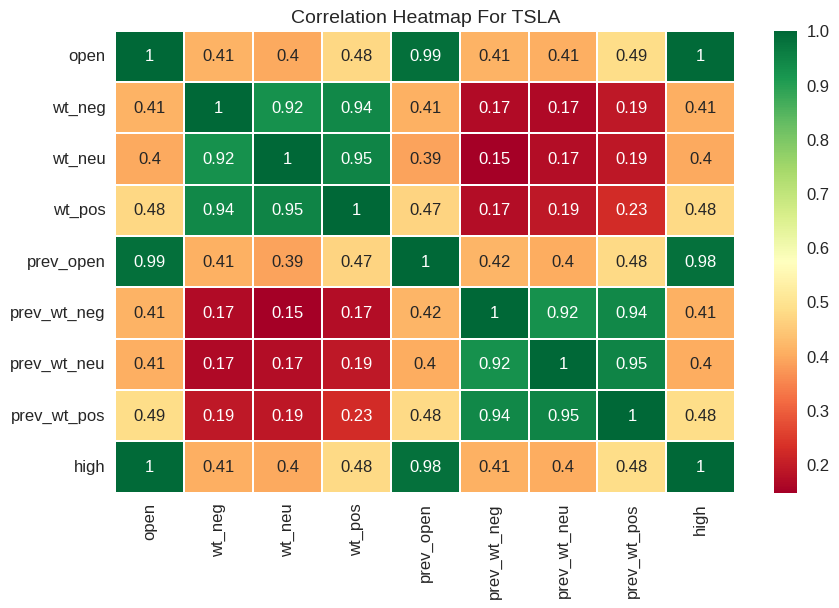

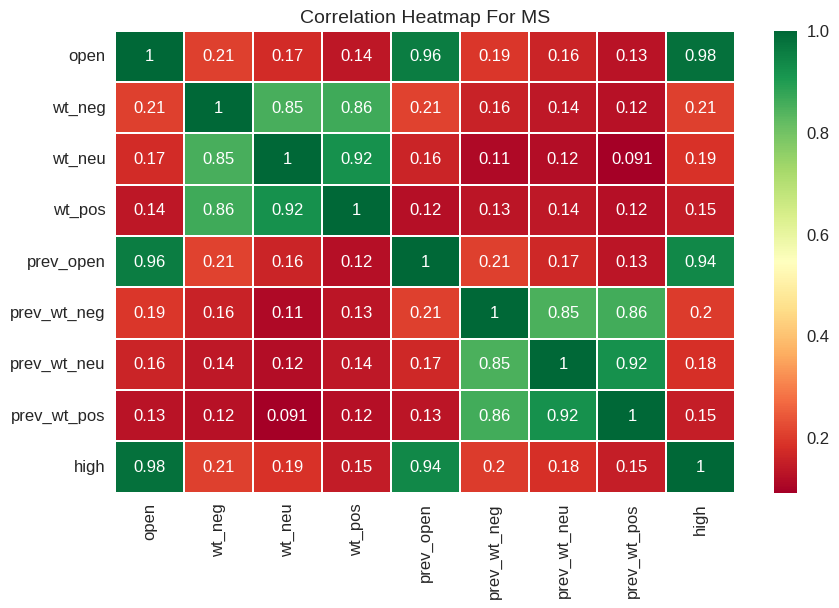

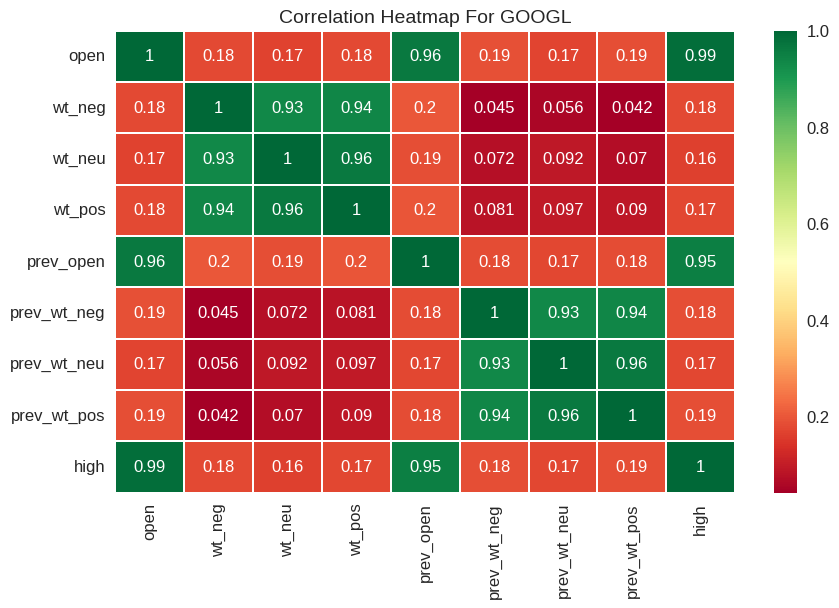

In [137]:
plot_corr_heatmaps(categories, tickers, both_open_norm_dfs)

======CURRENTLY WORKING ON TSLA======
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


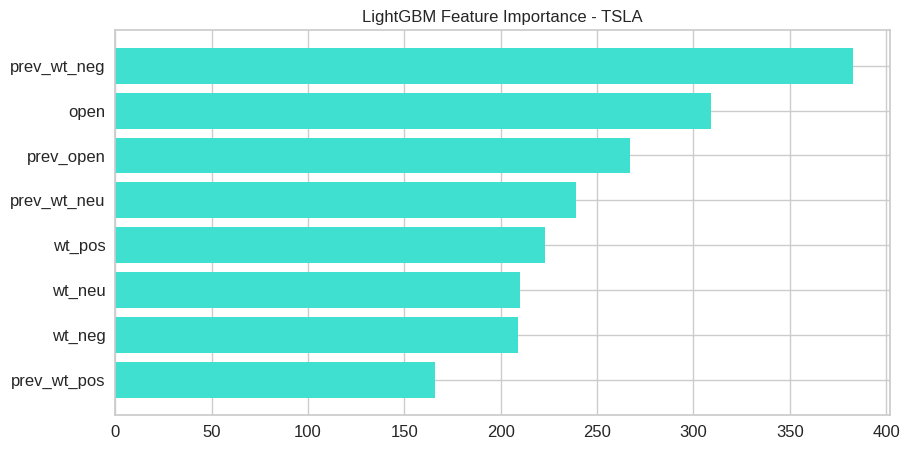

RMSE:			0.024678
MSE:			0.000609
MAE:			0.018699
R2 Score:		0.767607
Adj. R2 Score:		0.757503
Exp. Variance Score:	0.768004
Max Error:		0.071545
Predicted 	 Value
[0.42728084] 	 [0.44106778]
[0.43240677] 	 [0.4288953]
[0.44321263] 	 [0.41667355]
[0.41175685] 	 [0.48330191]
[0.51837419] 	 [0.50715405]
[0.5227211] 	 [0.52188911]
[0.43873315] 	 [0.47650106]
[0.43544228] 	 [0.47965506]
[0.44079253] 	 [0.48123206]
[0.51283341] 	 [0.48202056]
[0.52615245] 	 [0.48275981]
[0.44225761] 	 [0.44471463]
[0.44779487] 	 [0.46023821]
[0.44126512] 	 [0.42342506]
[0.41393502] 	 [0.45235321]
[0.45863675] 	 [0.46684191]
[0.43727622] 	 [0.48133061]
[0.51779619] 	 [0.49025052]
[0.5155462] 	 [0.47039015]
[0.40242519] 	 [0.4041068]
[0.43693796] 	 [0.4372731]
[0.43303962] 	 [0.43264068]
[0.43689346] 	 [0.43032446]
[0.44862377] 	 [0.42800827]
[0.40618574] 	 [0.40632444]
[0.37993985] 	 [0.36837784]
[0.36825396] 	 [0.36187267]
[0.34786161] 	 [0.32791785]
[0.32864833] 	 [0.32560166]
[0.31612058] 	 [0.32446819]
[0

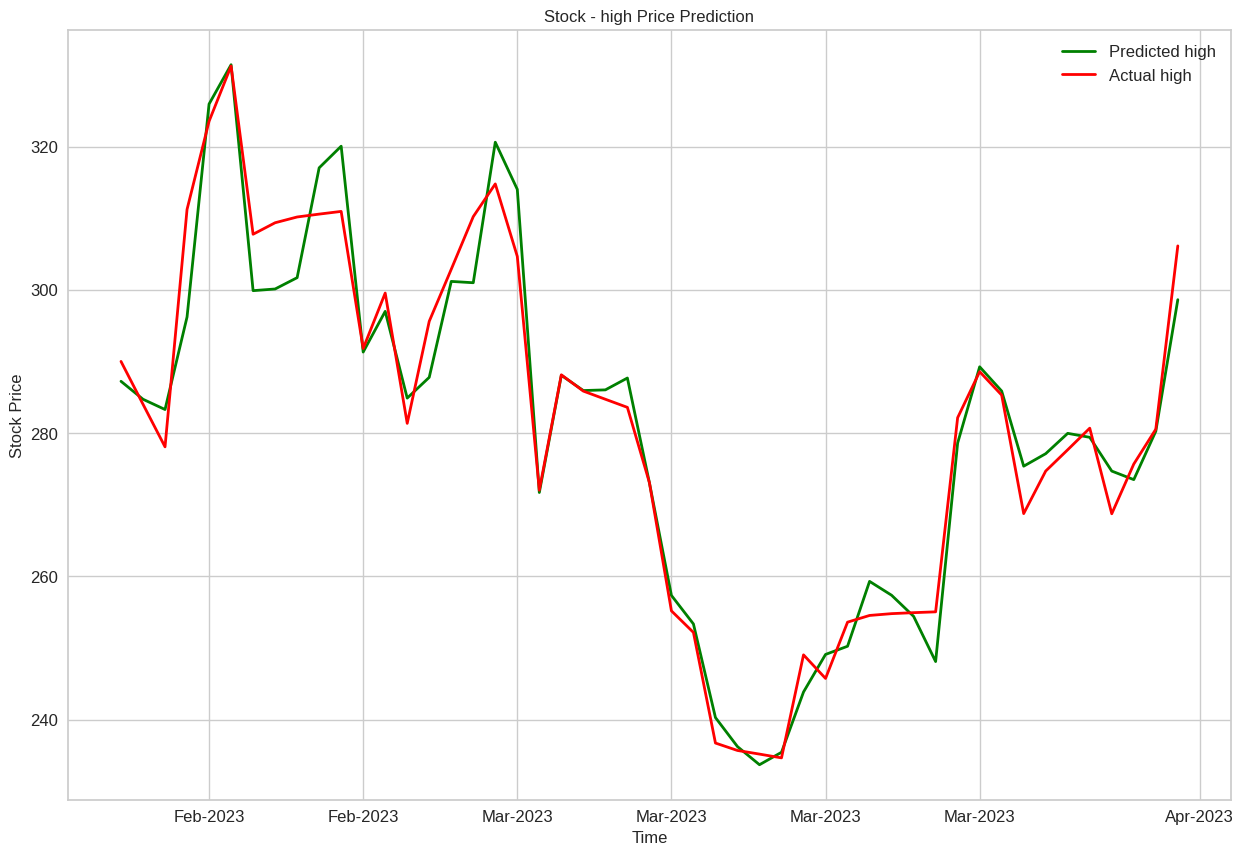

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


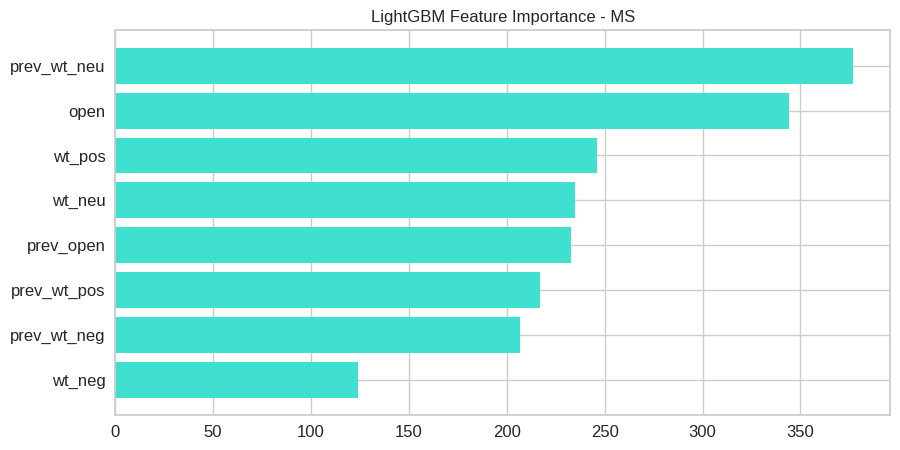

RMSE:			0.050620
MSE:			0.002562
MAE:			0.036194
R2 Score:		0.956238
Adj. R2 Score:		0.954336
Exp. Variance Score:	0.956894
Max Error:		0.156880
Predicted 	 Value
[0.9127117] 	 [0.92194919]
[0.92267995] 	 [0.93445458]
[0.88359562] 	 [0.94696006]
[0.88929119] 	 [1.]
[0.88629794] 	 [0.99870638]
[0.92386817] 	 [0.96765847]
[0.90101401] 	 [0.95817157]
[0.90815615] 	 [0.93617946]
[0.89418951] 	 [0.92496773]
[0.92212087] 	 [0.91936186]
[0.89669609] 	 [0.91418722]
[0.9104558] 	 [0.87408372]
[0.93394745] 	 [0.88917635]
[0.88948974] 	 [0.87020286]
[0.88538525] 	 [0.88098324]
[0.88124831] 	 [0.88658911]
[0.91887921] 	 [0.89176388]
[0.91725753] 	 [0.84044856]
[0.86924465] 	 [0.81759392]
[0.85895691] 	 [0.80077637]
[0.88720694] 	 [0.89003896]
[0.92248816] 	 [0.90642525]
[0.88267518] 	 [0.91461844]
[0.93059692] 	 [0.9228115]
[0.90382866] 	 [0.88227699]
[0.90963044] 	 [0.80638211]
[0.93954479] 	 [0.78266485]
[0.72005561] 	 [0.65588626]
[0.60481503] 	 [0.59508409]
[0.57973132] 	 [0.56446744]
[0.52983

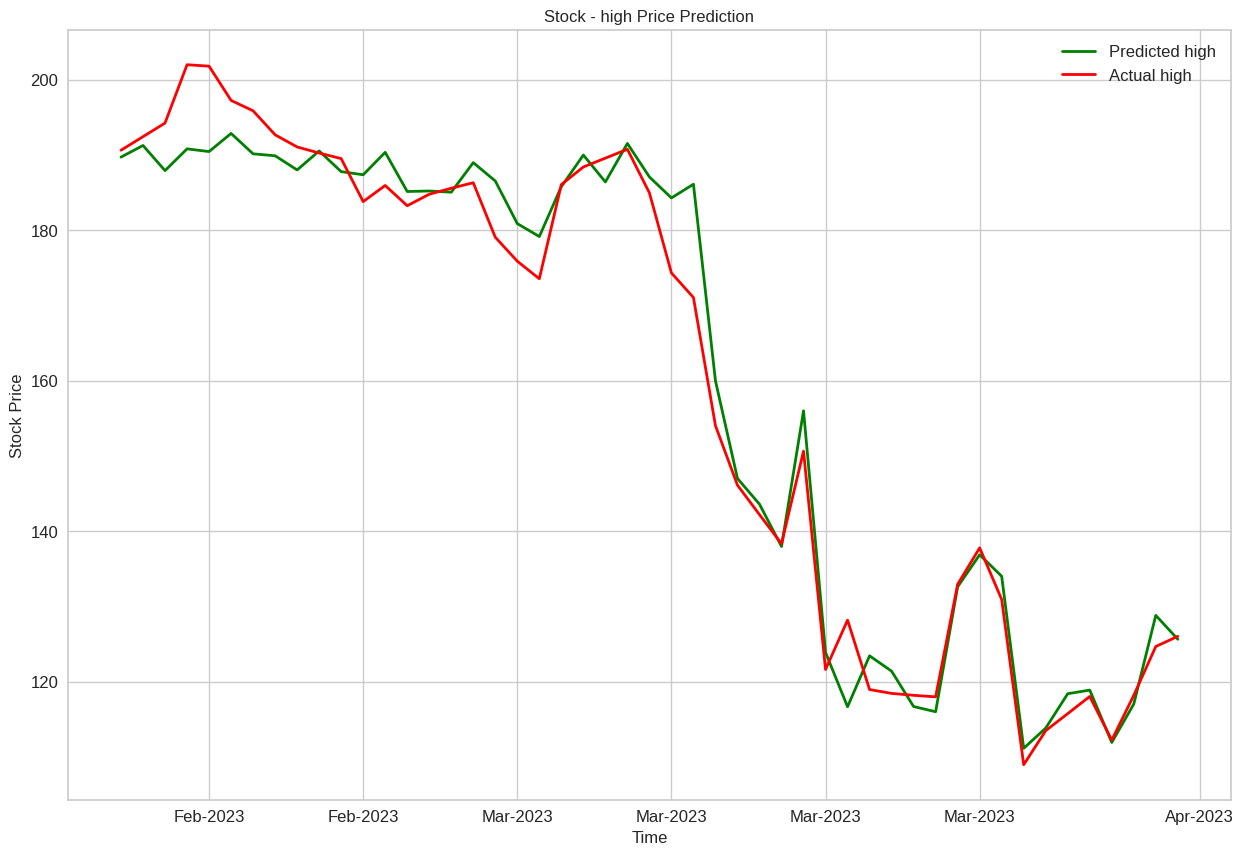

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


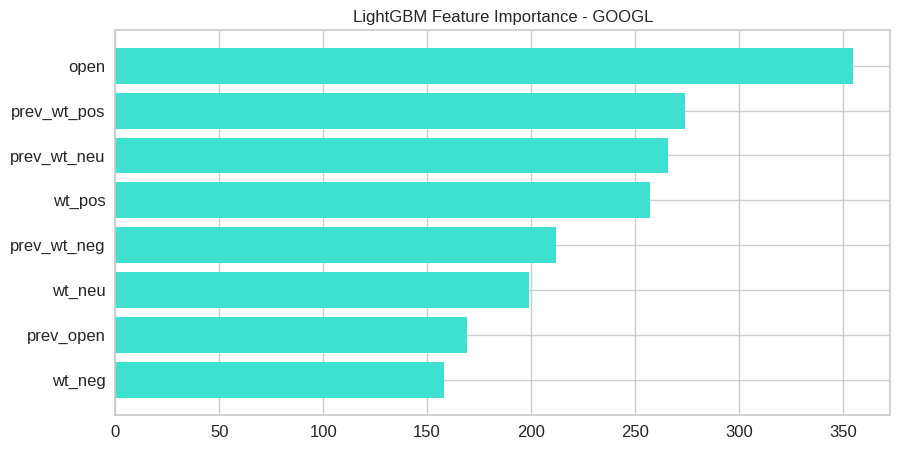

RMSE:			0.040639
MSE:			0.001652
MAE:			0.032343
R2 Score:		0.917001
Adj. R2 Score:		0.913393
Exp. Variance Score:	0.917288
Max Error:		0.111615
Predicted 	 Value
[0.28739896] 	 [0.26315796]
[0.31219207] 	 [0.25229747]
[0.31622058] 	 [0.24171538]
[0.24118872] 	 [0.23196882]
[0.24207117] 	 [0.29518254]
[0.28419707] 	 [0.310777]
[0.30314848] 	 [0.25174047]
[0.24643008] 	 [0.21748823]
[0.21645166] 	 [0.20022285]
[0.19763362] 	 [0.19159015]
[0.21422042] 	 [0.18323588]
[0.15471419] 	 [0.15566704]
[0.16220297] 	 [0.15093301]
[0.11345119] 	 [0.09384577]
[0.11972154] 	 [0.09774444]
[0.11775823] 	 [0.09969375]
[0.09118782] 	 [0.10136471]
[0.11370487] 	 [0.13116139]
[0.10313319] 	 [0.1255918]
[0.10827033] 	 [0.16040104]
[0.20959752] 	 [0.20077988]
[0.20820468] 	 [0.23196888]
[0.2525551] 	 [0.24756342]
[0.24196846] 	 [0.26315798]
[0.29148831] 	 [0.25480368]
[0.23649523] 	 [0.26287945]
[0.25955682] 	 [0.25090508]
[0.14421625] 	 [0.17460327]
[0.12104689] 	 [0.17154003]
[0.14355355] 	 [0.16986919]
[

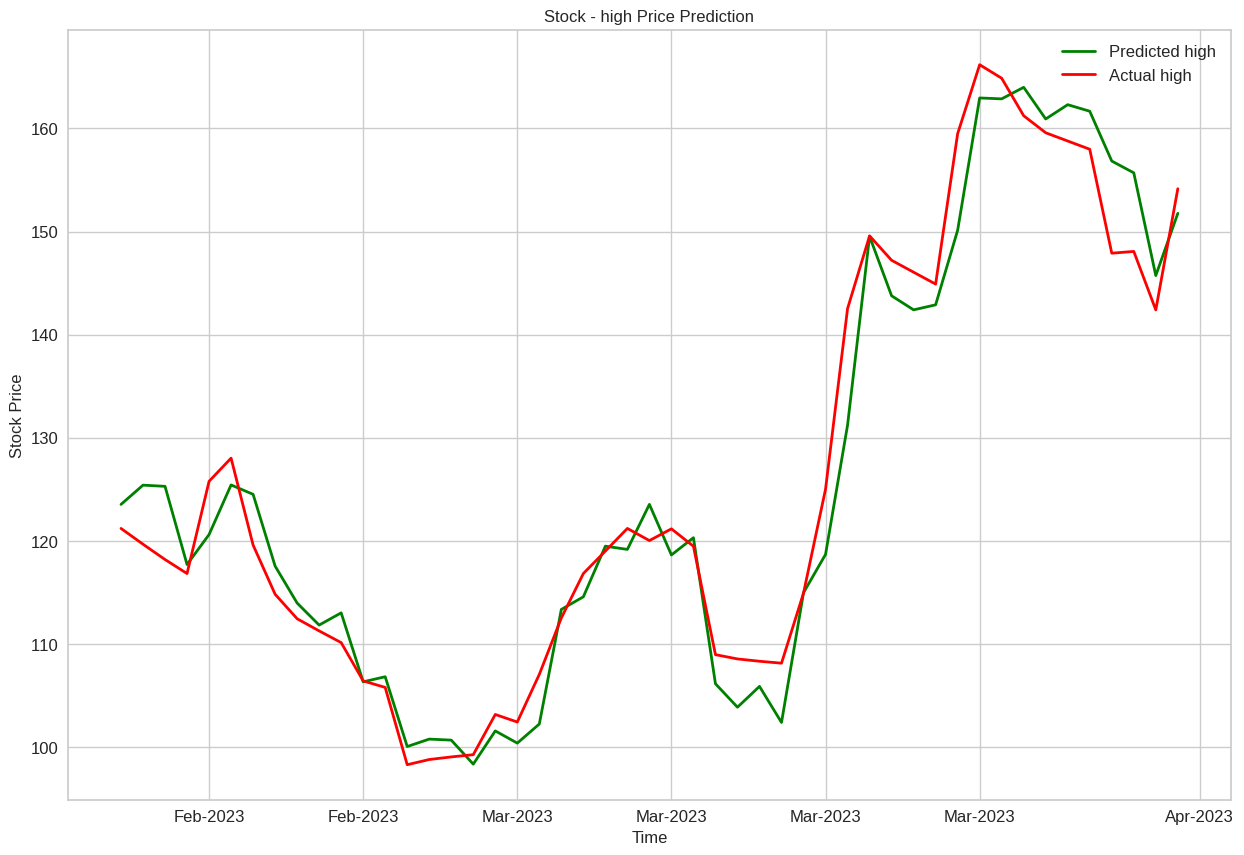

======FINISHED WORKING ON GOOGL======


In [146]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, both_open_dfs, output_label='high')
train_and_test_model(categories, tickers, both_open_norm_dfs, unscaled_op_labels,output_label='high')

# **Predicting Low Value**

In [147]:
both_open_dfs = append_prev_day_value(categories, tickers, merged_dfs, output_label='low')

both_open_dfs['TSLA']

,date,open,wt_neg,wt_neu,wt_pos,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,low
0,2022-08-02,294.003326,-22.682993,-25.073643,-37.357318,301.276672,-16.876412,-26.904634,-41.171774,292.666656
1,2022-08-03,305.000000,-2.331892,-6.009396,-13.196395,294.003326,-22.682993,-25.073643,-37.357318,301.149994
2,2022-08-04,311.000000,-1.167563,-2.196746,-3.635691,305.000000,-2.331892,-6.009396,-13.196395,305.000000
3,2022-08-05,302.670013,-16.216868,-16.855830,-160.879937,311.000000,-1.167563,-2.196746,-3.635691,285.543335
4,2022-08-06,298.840000,-5.747857,-10.603171,-13.781130,302.670013,-16.216868,-16.855830,-160.879937,287.320000
...,...,...,...,...,...,...,...,...,...,...
237,2023-03-27,194.419998,-232.793960,-281.636459,-465.958222,193.720000,-14.594635,-21.290344,-30.107518,189.940002
238,2023-03-28,192.000000,-13.191043,-12.029059,-33.769606,194.419998,-232.793960,-281.636459,-465.958222,185.429993
239,2023-03-29,193.130005,-50.816797,-73.301693,-115.862161,192.000000,-13.191043,-12.029059,-33.769606,189.440002
240,2023-03-30,195.580002,-150.363192,-88.522910,-161.982104,193.130005,-50.816797,-73.301693,-115.862161,194.419998


In [148]:
both_open_norm_dfs = normalize_datasets(categories, tickers, both_open_dfs,True,output_label='low')

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'low']
Data dimensions for TSLA: (242, 9) 

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'low']
Data dimensions for MS: (242, 9) 

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'low']
Data dimensions for GOOGL: (242, 9) 



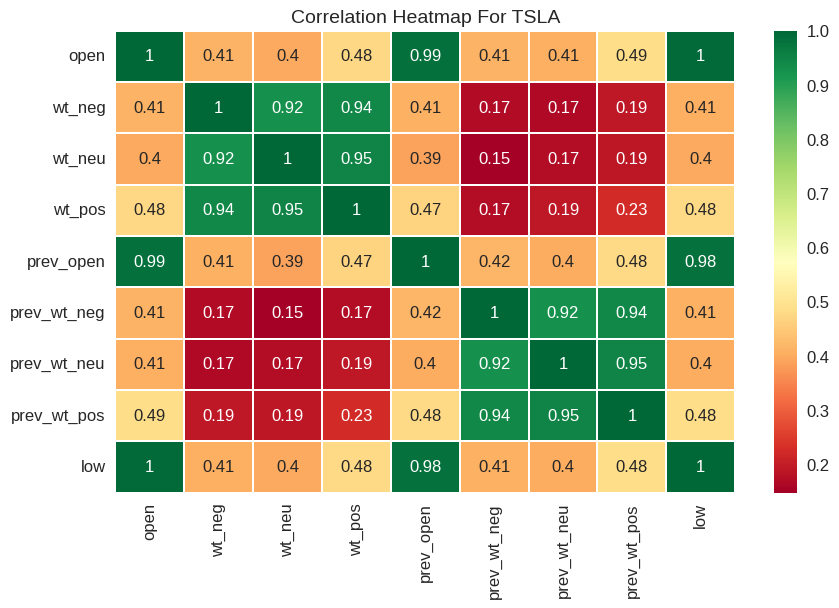

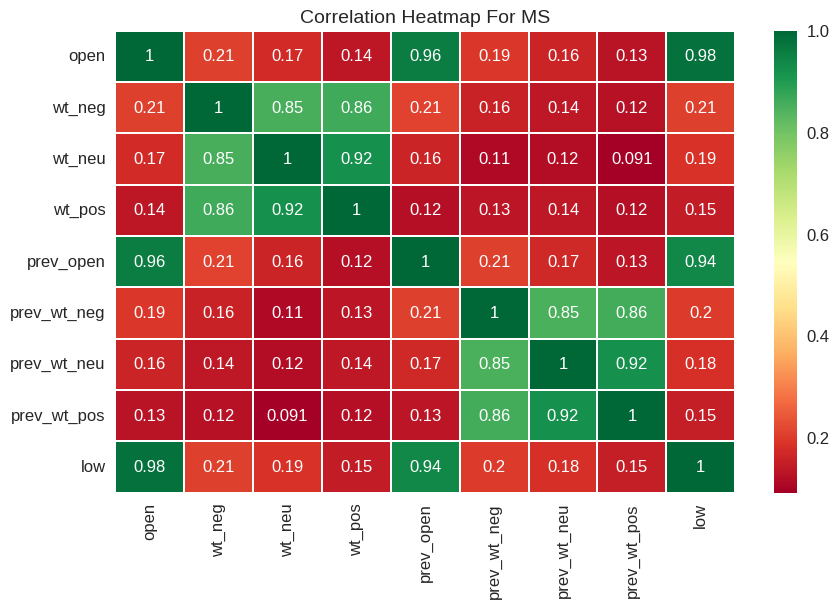

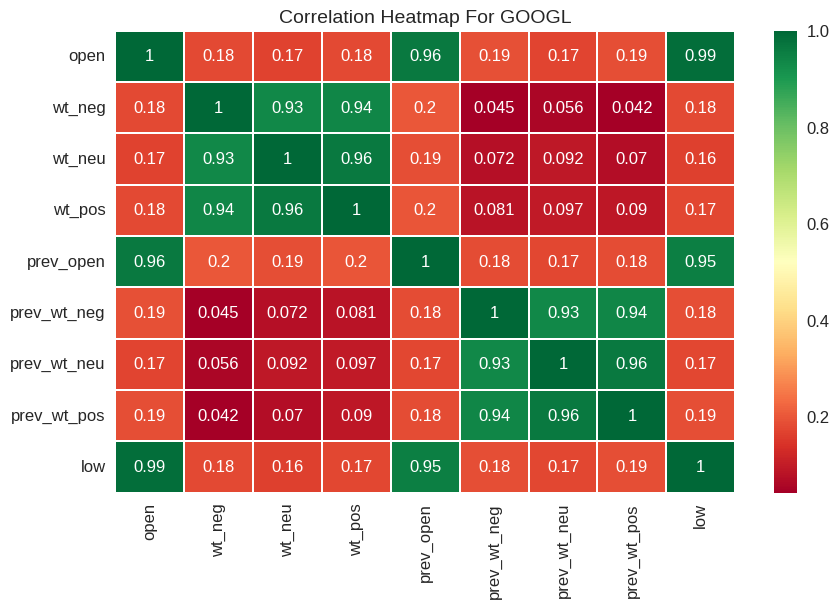

In [149]:
plot_corr_heatmaps(categories, tickers, both_open_norm_dfs)

======CURRENTLY WORKING ON TSLA======
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


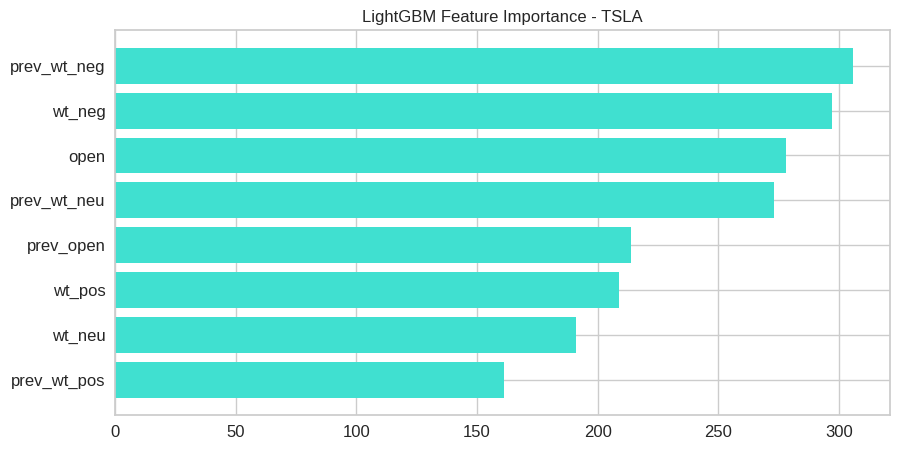

RMSE:			0.020268
MSE:			0.000411
MAE:			0.016264
R2 Score:		0.838287
Adj. R2 Score:		0.831256
Exp. Variance Score:	0.860812
Max Error:		0.053737
Predicted 	 Value
[0.4150452] 	 [0.43401878]
[0.42432556] 	 [0.42754089]
[0.43685556] 	 [0.421063]
[0.41890738] 	 [0.43004372]
[0.51104255] 	 [0.51185164]
[0.48737216] 	 [0.49089662]
[0.44350178] 	 [0.46959811]
[0.45024836] 	 [0.46891106]
[0.4441174] 	 [0.46856754]
[0.47499302] 	 [0.46842031]
[0.48283559] 	 [0.46822402]
[0.44040238] 	 [0.44152724]
[0.44502744] 	 [0.46385635]
[0.4444261] 	 [0.4465329]
[0.43224244] 	 [0.46729159]
[0.46718275] 	 [0.4776464]
[0.43431297] 	 [0.48805026]
[0.48030093] 	 [0.50026995]
[0.4856443] 	 [0.47460377]
[0.37642791] 	 [0.41321098]
[0.45643097] 	 [0.44692551]
[0.42894033] 	 [0.44550232]
[0.42186766] 	 [0.44481527]
[0.44636426] 	 [0.44407916]
[0.38281863] 	 [0.41365271]
[0.3832117] 	 [0.38371697]
[0.37384304] 	 [0.34695981]
[0.34323945] 	 [0.32698635]
[0.33023065] 	 [0.3158954]
[0.32258798] 	 [0.31034993]
[0.3231

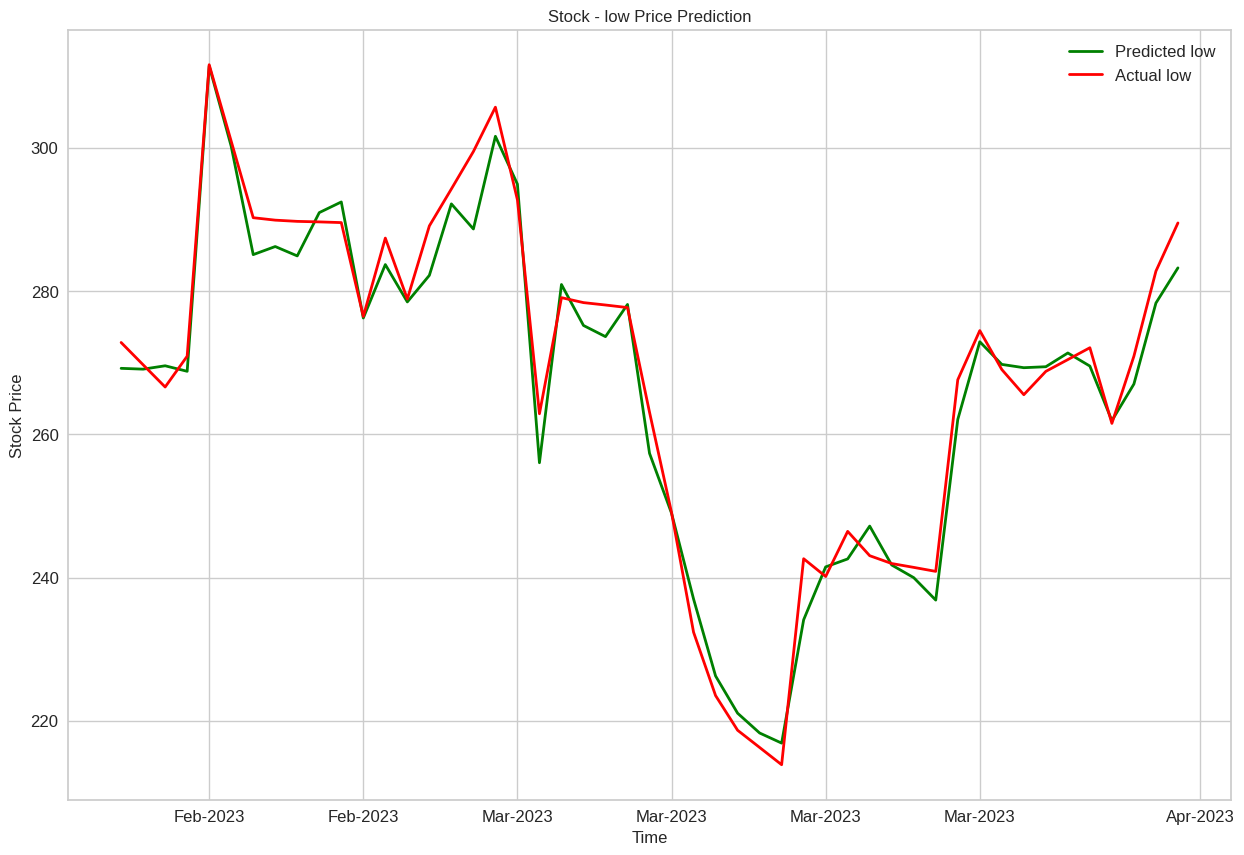

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


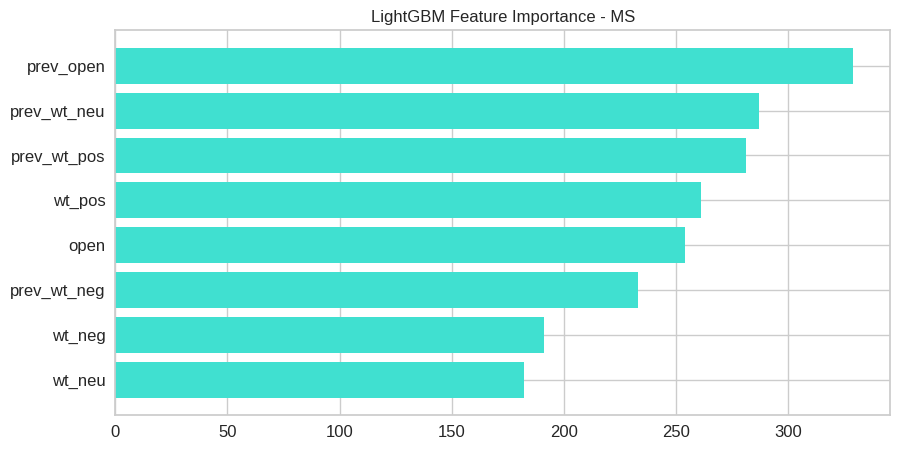

RMSE:			0.063460
MSE:			0.004027
MAE:			0.047560
R2 Score:		0.931749
Adj. R2 Score:		0.928782
Exp. Variance Score:	0.934896
Max Error:		0.236432
Predicted 	 Value
[0.89991465] 	 [0.93395087]
[0.92737416] 	 [0.93999195]
[0.89612854] 	 [0.94603319]
[0.89172133] 	 [0.97865489]
[0.86920593] 	 [1.]
[0.85480513] 	 [0.97221096]
[0.90576619] 	 [0.95167149]
[0.90680603] 	 [0.92911801]
[0.88747668] 	 [0.91784133]
[0.91485015] 	 [0.91220299]
[0.86364049] 	 [0.90656465]
[0.88896965] 	 [0.88401141]
[0.91410466] 	 [0.88723307]
[0.87910881] 	 [0.88360859]
[0.87837548] 	 [0.88320581]
[0.87033412] 	 [0.88280307]
[0.89780751] 	 [0.88240041]
[0.91879408] 	 [0.86951278]
[0.86895014] 	 [0.82923892]
[0.85801826] 	 [0.79782535]
[0.89804039] 	 [0.87716461]
[0.87982098] 	 [0.91018929]
[0.87112586] 	 [0.92670158]
[0.940816] 	 [0.94361652]
[0.90695635] 	 [0.85783332]
[0.90538931] 	 [0.83326626]
[0.92511499] 	 [0.68868295]
[0.68566263] 	 [0.58638759]
[0.60704557] 	 [0.53443419]
[0.579643] 	 [0.50865892]
[0.553213

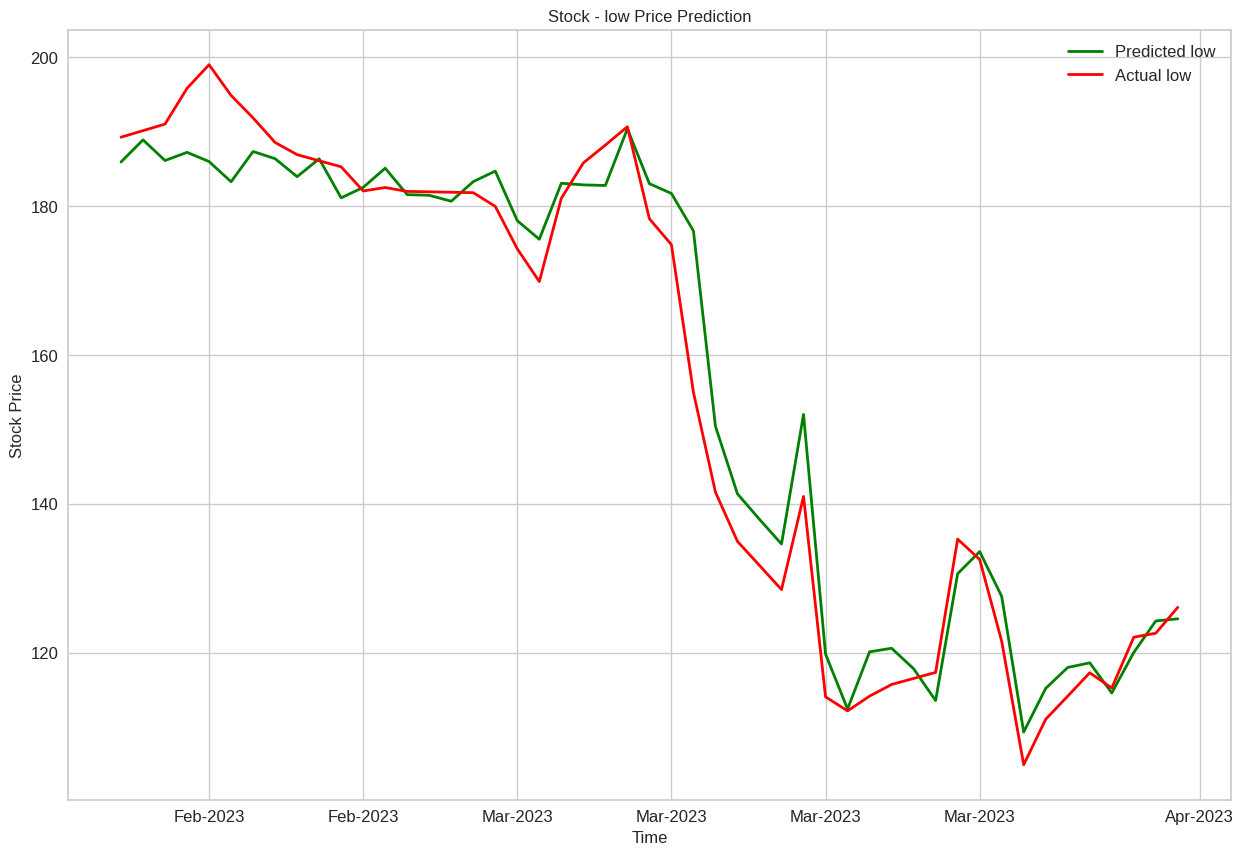

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


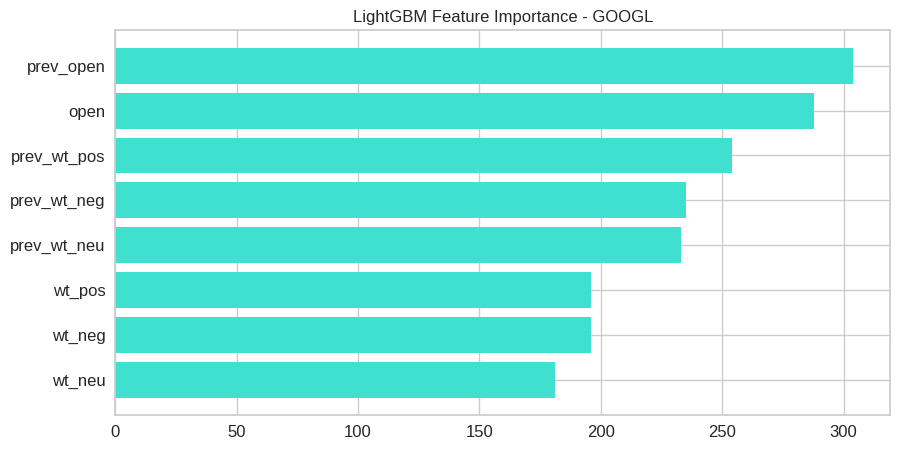

RMSE:			0.030347
MSE:			0.000921
MAE:			0.024998
R2 Score:		0.944224
Adj. R2 Score:		0.941799
Exp. Variance Score:	0.959549
Max Error:		0.079293
Predicted 	 Value
[0.25708978] 	 [0.28686335]
[0.29655037] 	 [0.28418239]
[0.2914365] 	 [0.28150132]
[0.23948735] 	 [0.23914223]
[0.24729514] 	 [0.28981247]
[0.29029267] 	 [0.30563006]
[0.27967865] 	 [0.26461132]
[0.25469812] 	 [0.24477221]
[0.22494725] 	 [0.23485264]
[0.21354016] 	 [0.2297588]
[0.21589758] 	 [0.224665]
[0.18243356] 	 [0.19490628]
[0.1788385] 	 [0.17211811]
[0.12277752] 	 [0.14048272]
[0.14428152] 	 [0.15067034]
[0.13552269] 	 [0.15576417]
[0.12259716] 	 [0.1608579]
[0.12281979] 	 [0.16032181]
[0.14568628] 	 [0.16970513]
[0.11029588] 	 [0.16756031]
[0.22202634] 	 [0.24423593]
[0.20752672] 	 [0.26487944]
[0.23785057] 	 [0.27533521]
[0.24369171] 	 [0.28579097]
[0.28108569] 	 [0.27319041]
[0.24994123] 	 [0.28579097]
[0.25690855] 	 [0.22949076]
[0.16149798] 	 [0.18927629]
[0.15144691] 	 [0.1761395]
[0.1557568] 	 [0.16943709]
[0.13

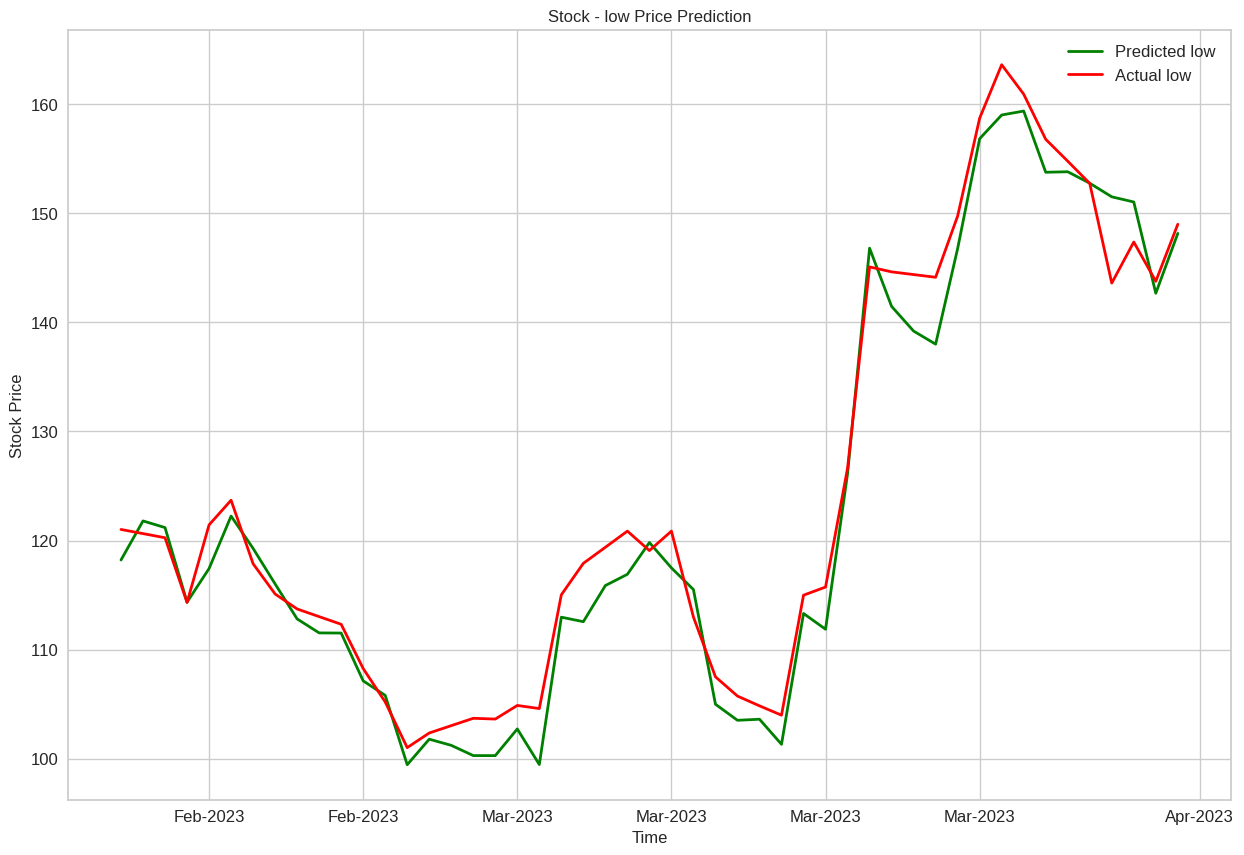

======FINISHED WORKING ON GOOGL======


In [151]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, both_open_dfs, output_label='low')
train_and_test_model(categories, tickers, both_open_norm_dfs, unscaled_op_labels,output_label='low')